In [8]:
import pandas as pd
import numpy as np
import os
import sys
from matplotlib import pyplot as plt
chemin_dev = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if chemin_dev not in sys.path:
    sys.path.append(chemin_dev)
from options_pricing.scripts import data_processing as dp
from options_pricing.scripts import black_scholes as bs
from options_pricing.scripts import linear_reg as lr
from sklearn.linear_model import LinearRegression
from scipy.stats import norm, shapiro
import statsmodels.api as sm
from sklearn.feature_selection import f_regression

In [151]:
df_options = pd.read_csv('../../data/options/options_processed.csv')
df_options_c = df_options.loc[df_options['call_put'] == 'Call']

In [167]:
params = {
    'test_size' : 0.1, # If we choose 0, we test on all the rest of the data (not used for training or validation
    'n_rows' : 1000,
    'standardize' : True,
    'fit_intercept' : True , # Default is True but our data are already centered 'If set to False, no intercept will be used in calculations (i.e. data is expected to be centered).'
    'features': ['strike','vol', 'delta', 'gamma', 'theta', 'vega', 'rho', 'stock_price','time_to_maturity', 'interest_rate'],
}

In [168]:
X_train, X_test, y_train, y_test, scaler = dp.create_train_test_set_by_act_symbol(
    df_options_c,
    params['test_size'],
    params['n_rows'], 
    params['features'],
    params['standardize']
    )
# The explicative variables are scaled and standardized

In [169]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1188, 10), (132, 10), (1188,), (132,))

In [170]:
lin_reg_model = LinearRegression(fit_intercept=params['fit_intercept'])

In [171]:
lin_reg_model.fit(X_train, y_train)

LinearRegression()

In [172]:
y_pred = lin_reg_model.predict(X_test)
bs.compute_metrics(y_test, y_pred)

MAPE:  6.110021363696759
MAE:  10.753129777871536
MSE:  231.07927243360163
R2:  0.9675825515423621
-----------------------------------




(6.110021363696759, 10.753129777871536, 231.07927243360163, 0.9675825515423621)

The first observation, regarding the parameters standardize & fit_intercept is 

| standardize      | fit_intercept      | MSE      |
| -------------- | -------------- | -------------- |
| False | True |  8.3346 |
| True | True | 8.3346 |
| False | False | 8.3571 |
| True | False | 38.1083 |


## Coefficients 

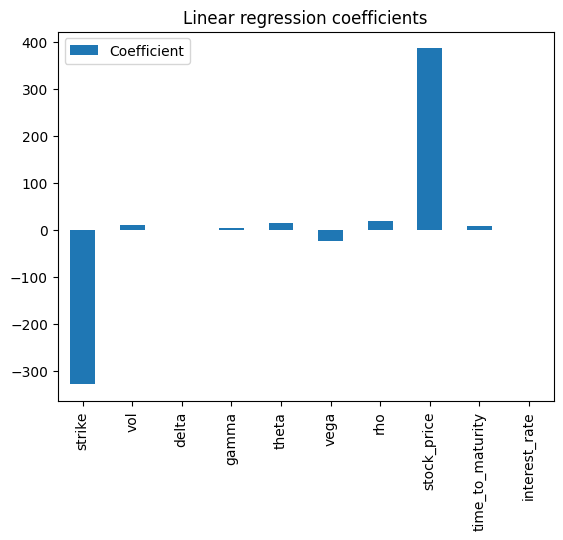

In [173]:
coefficients = pd.DataFrame(lin_reg_model.coef_, X_train.columns, columns=['Coefficient'])
coefficients.plot(kind='bar')
plt.title('Linear regression coefficients')
plt.show()

Case when data are not normalize : 
We can interpret this graph as follow. The bars represent the increase or decrease of the option price when the variables increase. 

Effect size problems : strike (tens €) vs volatility (0.4)

## Feature selection

$
\left\{\begin{matrix}
H_0 : b_j  = 0 \quad i.e :  \text{The variables have no correlation with the option price}\\ 
H_1 : b_j \neq 0
\end{matrix}\right.
$ 

We use the statistic
$ F = \frac{MSR}{MSE}$ With 

$MSR : \text{Mean regression sum of squares : average square between the predicted values and the mean of the dependant variable }$

$MSE : \text{moyenne dispersion résiduel}$

In [159]:
F_values, p_values = f_regression(X_train, y_train)

# Créer un DataFrame pour afficher les résultats
anova_results = pd.DataFrame({
    'Feature': [feature for feature in X_train.columns],
    'F_value': F_values,
    'p_value': p_values
})

print(anova_results)

            Feature      F_value        p_value
0            strike   209.274642   8.389725e-44
1               vol    12.903145   3.414605e-04
2             delta   783.362992  9.151101e-133
3             gamma   288.816251   3.872694e-58
4             theta    59.803897   2.227171e-14
5              vega    65.925223   1.164020e-15
6               rho  1762.365212  8.847606e-237
7       stock_price   403.929380   1.501206e-77
8  time_to_maturity    10.144905   1.484700e-03
9     interest_rate     0.108720   7.416642e-01


In [160]:
r2 = lin_reg_model.score(X_test, y_test)
print(r2)

0.9675825515423605


$R^2$ indicates the proportion of variation in the y-variable that is due to variation in the x-variables. 

## Analysis of variance

In [161]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
df_train = pd.DataFrame(X_train)
df_train['y'] = y_train

In [165]:
formula = 'y ~ ' + ' + '.join(df_train.columns[:-1])
# 'y ~ strike + vol + delta + gamma + theta + vega + rho + stock_price + time_to_maturity + interest_rate'
model_sm = ols(formula, data=df_train).fit()

print(model_sm.summary())
anova_results = anova_lm(model_sm)
# print(anova_results)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     3648.
Date:                Thu, 23 May 2024   Prob (F-statistic):               0.00
Time:                        12:29:01   Log-Likelihood:                -4750.3
No. Observations:                1188   AIC:                             9523.
Df Residuals:                    1177   BIC:                             9579.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -71.1481      5.284  

We constat that the f_regression is not sensitive to normalization but anova is. 

Looking at the document, we can constat that f_regression is based on the the Pearson correlation : 
$$\text{corr}(X[:, i], y) = \frac{E[(X[:, i] - \text{mean}(X[:, i])) \cdot (y - \text{mean}(y))]}{\text{std}(X[:, i]) \cdot \text{std}(y)}$$
That already includes normalization. 

It is not the case for ANOVA, during the computation of $MSR$ and $MSE$

## Residuals analysis

In [70]:
y_pred_train = lin_reg_model.predict(X_train)

Computations of standardized residuals
- We compute the matrice $R = I_n-X(X^TX)^{-1}X^T$
remark : $R = I_n - H$ where $H$ is the hat matrice such that $\hat{Y} = HY$
- We compute the residuals : $ \hat{\varepsilon }_i = Y_i - \hat{Y_i}$
- Compute variance : $\hat{\sigma}^2 = \frac{1}{n-p}\sum_{i=1}^n\hat{\epsilon_i}^2$ 
- $\tilde{\varepsilon_i} = \frac{\hat{\varepsilon }_i}{\sqrt{\hat{\sigma}^2\times r_{ii}}}$


In [71]:
p = len(params['features'])
standardized_residuals = lr.compute_standardized_residuals_fast(X_train, y_train, y_pred_train, p)

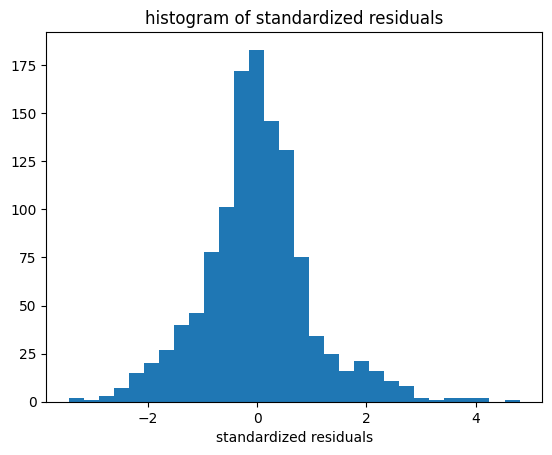

In [72]:
plt.hist(standardized_residuals, bins=30)
plt.xlabel('standardized residuals')
plt.title('histogram of standardized residuals')
plt.show()

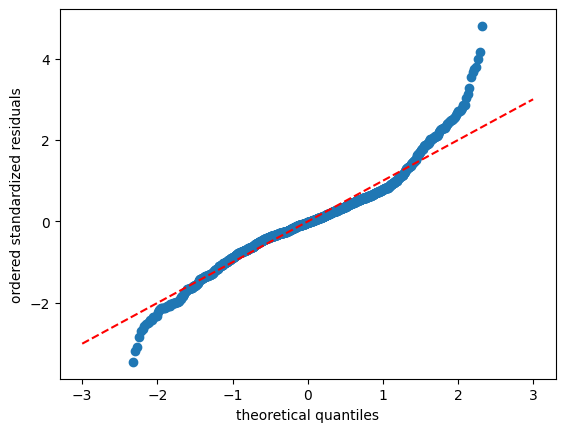

In [73]:
# We use the quantile function ppf of normal distribution
theoretical_quantiles = norm.ppf(np.linspace(0.01, 0.99, len(standardized_residuals)))
residuals_sorted = np.sort(standardized_residuals)
plt.scatter(theoretical_quantiles, residuals_sorted)
plt.xlabel('theoretical quantiles')
plt.ylabel('ordered standardized residuals')
plt.plot([-3, 3], [-3, 3], color='red', linestyle='--')


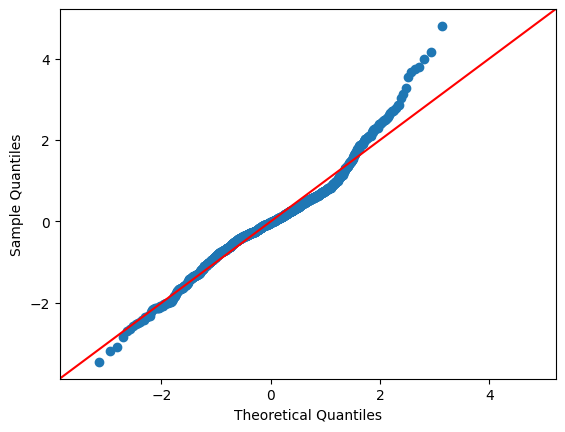

In [74]:
sm.qqplot(standardized_residuals, line ='45')
plt.show()

Text(0, 0.5, 'standardized residuals')

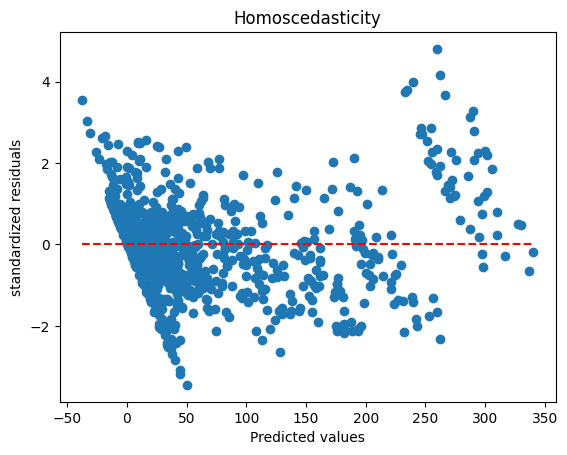

In [76]:
plt.scatter(y_pred_train, standardized_residuals)
plt.plot([min(y_pred_train), max(y_pred_train)], [0, 0], color='red', linestyle='--')
plt.title('Homoscedasticity')
plt.xlabel('Predicted values')
plt.ylabel('standardized residuals')

In [75]:
_, p_value  = shapiro(standardized_residuals)
print(p_value)

6.9742975688632674e-15


In [31]:
import pandas as pd
dict_result_by_act = {
    'n_row_train': [500, 1000, 2000, 3000, 5000, 10000, 50000, 100000],
    'GP' : [161.519, 110.82, 10.22, 9.67, 14.59, np.nan, np.nan, np.nan],
    'DL' : [2667, 1579.3, 4435.1, 1706.7, 3226.7, 17.81, 93.39, 137.2],
    'RL' : [1805.7, 485.48, 1322.2, 2406.16, 295.07, 208.6, 35.66, 19.32],
}
df_by_act = pd.DataFrame(dict_result_by_act)

In [32]:
df_by_act

,n_row_train,GP,DL,RL
0,500,161.519,2667.00,1805.70
1,1000,110.820,1579.30,485.48
2,2000,10.220,4435.10,1322.20
3,3000,9.670,1706.70,2406.16
4,5000,14.590,3226.70,295.07
5,10000,NaN,17.81,208.60
6,50000,NaN,93.39,35.66
7,100000,NaN,137.20,19.32


In [33]:
dict_result_by_idx = {
    'n_row_train': [500, 1000, 2000, 3000, 5000, 10000, 50000, 100000],
    'GP' : [157.4, 156.79, 158.5, 134.23, 138.5, np.nan, np.nan, np.nan],
    'DL' : [120.2, 26.8, 38.94, 42.09, 6.777, 5.21, 5.27, 6.15],
    'RL' : [440.98, 14.93, 10.30, 46.474, 8.61, 10.66, 12.273, 8.801],
}
df_by_idx = pd.DataFrame(dict_result_by_idx)

In [15]:
dict_result_by_random = {
    'n_row_train': [500, 1000, 2000, 3000, 5000, 10000, 50000, 100000],
    'GP' : [90.4, 101.3, 106.15, 78.65, 55.2, np.nan, np.nan, np.nan],
    'DL' : [24.32, 23.2, 4.65, 4.75, 5.83, 8.34, 0.544, 0.728],
    'RL' : [14.19, 8.638, 8.21, 8.966, 8.11, 8.224, 8.572, 8.528],
}
df_by_random = pd.DataFrame(dict_result_by_random)


In [49]:
def plot_results(dict_result, title):
    plt.plot(dict_result['n_row_train'], dict_result['GP'], label='GP')
    plt.plot(dict_result['n_row_train'], dict_result['DL'], label='NN')
    plt.plot(dict_result['n_row_train'], dict_result['RL'], label='LR')
    # ajoute une ligne horizinale pour la baseline
    plt.axhline(y=2.8, color='black', linestyle='--', label = 'BS')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Number of training samples')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.title(title)
    plt.show() 

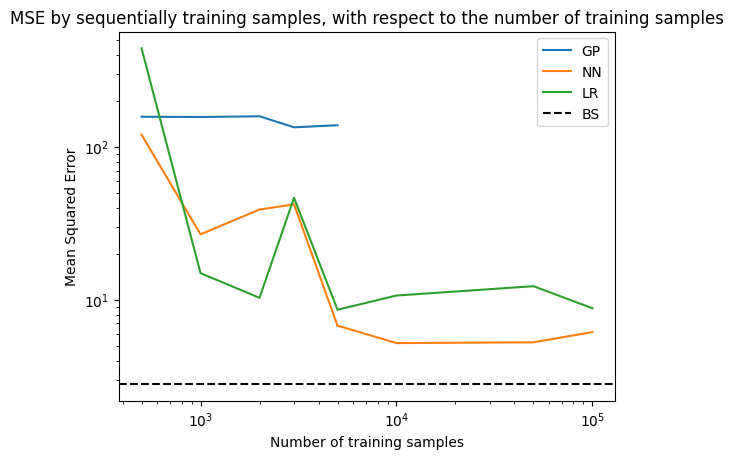

In [52]:
plot_results(dict_result_by_idx, 'MSE by sequentially training samples, with respect to the number of training samples')